<a href="https://colab.research.google.com/github/yashv04/Match-Winning-Pressure-Index/blob/main/Match_Winning_Pressure_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max.colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Pressure Index Model

In [24]:
df = pd.read_csv('deliveries_till_2024.csv')
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN


In [25]:
# Create cumulative score and wickets lost for each innings
df['runs_cumsum'] = df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
df['wickets_cumsum'] = df.groupby(['match_id', 'inning'])['is_wicket'].cumsum()

# Calculate required run rate dynamically (for chasing teams)
df['balls_remaining'] = 120 - df.groupby(['match_id', 'inning']).cumcount()  # For T20
df['runs_remaining'] = df.groupby(['match_id', 'inning'])['total_runs'].transform('sum') - df['runs_cumsum']
df['req_run_rate'] = df['runs_remaining'] / (df['balls_remaining'] / 6 + 0.0001)

In [26]:
# Define Pressure Conditions
def classify_pressure(row):
    pressure = 0

    # Batting pressure
    if row['inning'] == 2 and row['req_run_rate'] > 10:
        pressure += 2
    if row['wickets_cumsum'] >= 7:
        pressure += 2
    if row['over'] >= 16 and row['inning'] == 2:
        pressure += 2

    # Bowling pressure
    if row['inning'] == 1 and row['over'] >= 17 and row['runs_cumsum'] >= 150:
        pressure += 2

    # Final over / Eliminator tag can be added from match metadata
    return pressure

df['pressure_score'] = df.apply(classify_pressure, axis=1)
df['is_pressure'] = df['pressure_score'] >= 3

In [27]:
#Player Pressure Stats

# Batting Impact in Pressure
batting_pressure = df[df['is_pressure'] & (df['batter'] != 'nan')].groupby('batter').agg(
    pressure_runs=('batsman_runs', 'sum'),
    pressure_balls=('ball', 'count'),
    pressure_events=('is_pressure', 'count')
).reset_index()

batting_pressure['batting_pressure_index'] = batting_pressure['pressure_runs'] / batting_pressure['pressure_events']

# Bowling Impact in Pressure
bowling_pressure = df[df['is_pressure'] & (df['bowler'] != 'nan')].groupby('bowler').agg(
    pressure_runs_conceded=('total_runs', 'sum'),
    pressure_wickets=('is_wicket', 'sum'),
    pressure_balls=('ball', 'count'),
    pressure_events=('is_pressure', 'count')
).reset_index()

# Invert runs conceded to reflect impact – less runs conceded = higher impact
bowling_pressure['bowling_pressure_index'] = (bowling_pressure['pressure_wickets'] * 20 - bowling_pressure['pressure_runs_conceded']) / bowling_pressure['pressure_events']

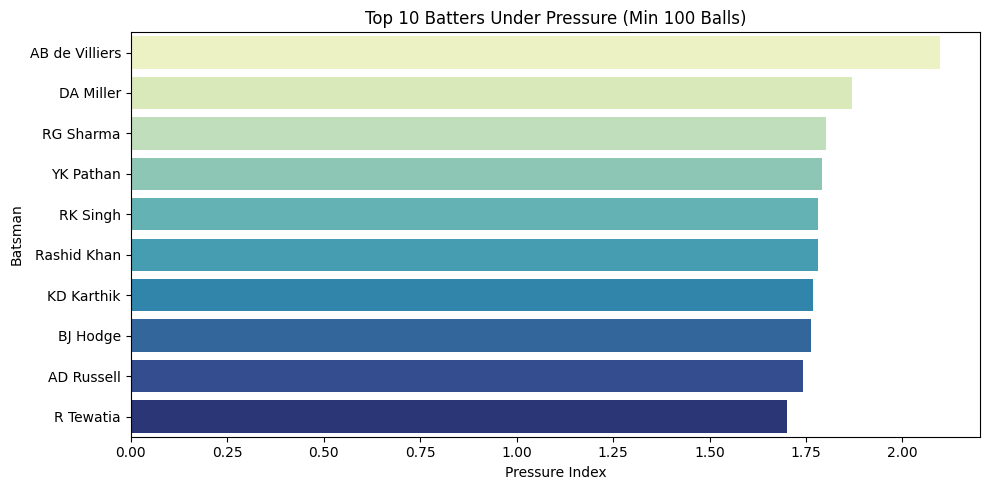

In [28]:
#Visualize Top Pressure Performers
# Top 10 Batting Pressure Index

min_balls_faced = 100

filtered_batting = batting_pressure[batting_pressure['pressure_balls'] >= min_balls_faced].copy()

# Recalculate Pressure Index
filtered_batting['batting_pressure_index'] = (
    filtered_batting['pressure_runs'] / filtered_batting['pressure_events']
)

# Sort and display
top_batters = filtered_batting.sort_values('batting_pressure_index', ascending=False).head(10)

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(x='batting_pressure_index', y='batter', data=top_batters, palette='YlGnBu')
plt.title('Top 10 Batters Under Pressure (Min 100 Balls)')
plt.xlabel('Pressure Index')
plt.ylabel('Batsman')
plt.tight_layout()
plt.show()


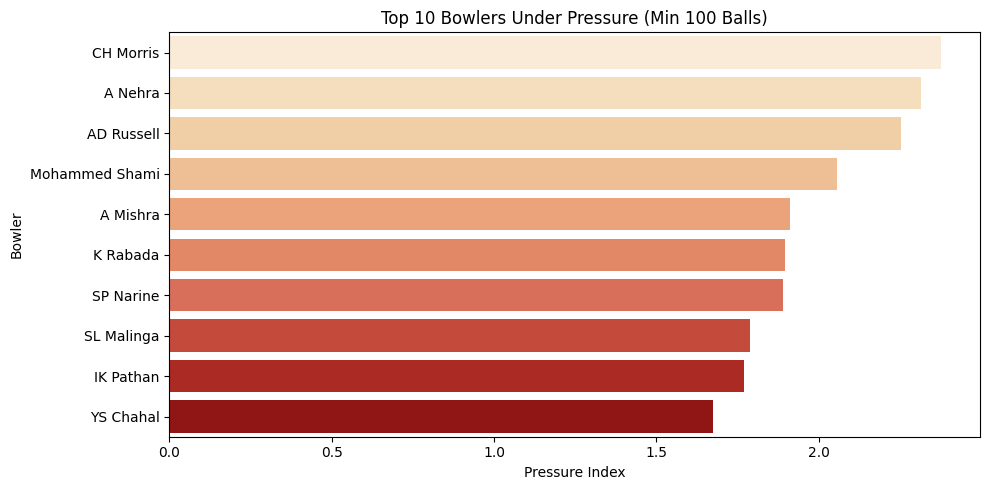

In [29]:
# Top 10 Bowling Pressure Index
# Set minimum threshold for balls bowled
min_balls_bowled = 100

filtered_bowling = bowling_pressure[bowling_pressure['pressure_balls'] >= min_balls_bowled].copy()

# Recalculate Pressure Index
filtered_bowling['bowling_pressure_index'] = (
    (filtered_bowling['pressure_wickets'] * 20 - filtered_bowling['pressure_runs_conceded'])
    / filtered_bowling['pressure_events']
)

# Sort and display
top_bowlers = filtered_bowling.sort_values('bowling_pressure_index', ascending=False).head(10)

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(x='bowling_pressure_index', y='bowler', data=top_bowlers, palette='OrRd')
plt.title('Top 10 Bowlers Under Pressure (Min 100 Balls)')
plt.xlabel('Pressure Index')
plt.ylabel('Bowler')
plt.tight_layout()
plt.show()


Phase-Wise Pressure Index Model

In [59]:
def classify_pressure(row):
    pressure = 0

    # General pressure (for all overs)
    if row['inning'] == 2 and row['req_run_rate'] > 8.5:
        pressure += 1
    if row['wickets_cumsum'] >= 3:
        pressure += 1

    # Powerplay-specific pressure
    if row['over'] <= 5:  # Powerplay
        if row['wickets_cumsum'] >= 2:
            pressure += 2
        if row['req_run_rate'] > 9:
            pressure += 1

    # Death overs pressure (for bowling)
    if row['inning'] == 1 and row['over'] >= 17 and row['runs_cumsum'] >= 140:
        pressure += 1

    return pressure

In [60]:
df['pressure_score'] = df.apply(classify_pressure, axis=1)
df['is_pressure'] = df['pressure_score'] >= 2  # Lowered threshold from 3 to 2

In [61]:
df['phase'] = df['over'].apply(get_phase)  # Use the adjusted get_phase() function

powerplay_pressure_balls = df[(df['is_pressure']) & (df['phase'] == 'Powerplay')]
print(f"Pressure deliveries in Powerplay: {len(powerplay_pressure_balls)}")

Pressure deliveries in Powerplay: 19791


In [62]:
def get_phase(over):
    if 1 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle Overs'
    elif 16 <= over <= 20:
        return 'Death Overs'
    else:
        return 'Other'

df['phase'] = df['over'].apply(get_phase)

In [63]:
#Phase-Wise Batting Pressure Index
min_balls_faced = 100

batting_phase_pressure = (
    df[df['is_pressure']]
    .groupby(['batter', 'phase'])
    .agg(
        pressure_runs=('batsman_runs', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('is_pressure', 'count')
    )
    .reset_index()
)

# Filter out low-sample players
batting_phase_pressure = batting_phase_pressure[batting_phase_pressure['pressure_balls'] >= min_balls_faced]

# Calculate Index
batting_phase_pressure['batting_pressure_index'] = (
    batting_phase_pressure['pressure_runs'] / batting_phase_pressure['pressure_events']
)

In [64]:
#Phase-Wise Bowling Pressure Index

min_balls_bowled = 100

bowling_phase_pressure = (
    df[df['is_pressure']]
    .groupby(['bowler', 'phase'])
    .agg(
        pressure_runs_conceded=('total_runs', 'sum'),
        pressure_wickets=('is_wicket', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('is_pressure', 'count')
    )
    .reset_index()
)

# Filter out low-sample players
bowling_phase_pressure = bowling_phase_pressure[bowling_phase_pressure['pressure_balls'] >= min_balls_bowled]

# Calculate Index (higher = better)
bowling_phase_pressure['bowling_pressure_index'] = (
    (bowling_phase_pressure['pressure_wickets'] * 20 - bowling_phase_pressure['pressure_runs_conceded']) /
    bowling_phase_pressure['pressure_events']
)

Visualize Phase-Wise Top Performers

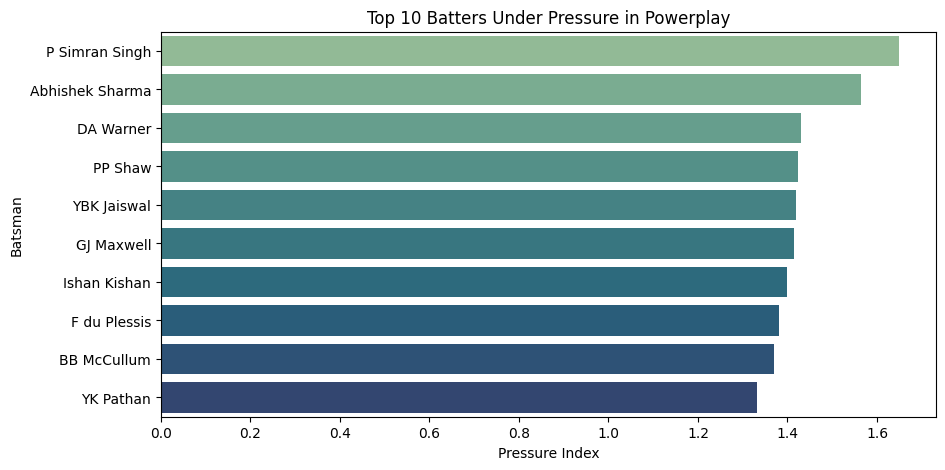

In [65]:
# Powerplay Batting Pressure Index

powerplay_bat = batting_phase_pressure[batting_phase_pressure['phase'] == 'Powerplay'] \
    .sort_values('batting_pressure_index', ascending=False).head(10)

if powerplay_bat.empty:
       print("No batsmen found meeting the criteria for Powerplay Batting Pressure Index.")
else:
 plt.figure(figsize=(10, 5))
 sns.barplot(x='batting_pressure_index', y='batter', data=powerplay_bat, palette='crest')
 plt.title('Top 10 Batters Under Pressure in Powerplay')
 plt.xlabel('Pressure Index')
 plt.ylabel('Batsman')
 plt.show()

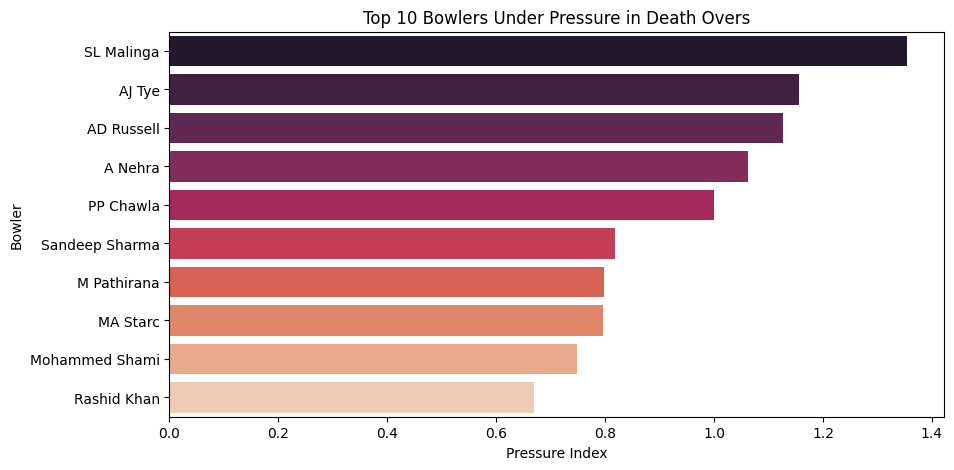

In [66]:
death_bowl = bowling_phase_pressure[bowling_phase_pressure['phase'] == 'Death Overs'] \
    .sort_values('bowling_pressure_index', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='bowling_pressure_index', y='bowler', data=death_bowl, palette='rocket')
plt.title('Top 10 Bowlers Under Pressure in Death Overs')
plt.xlabel('Pressure Index')
plt.ylabel('Bowler')
plt.show()

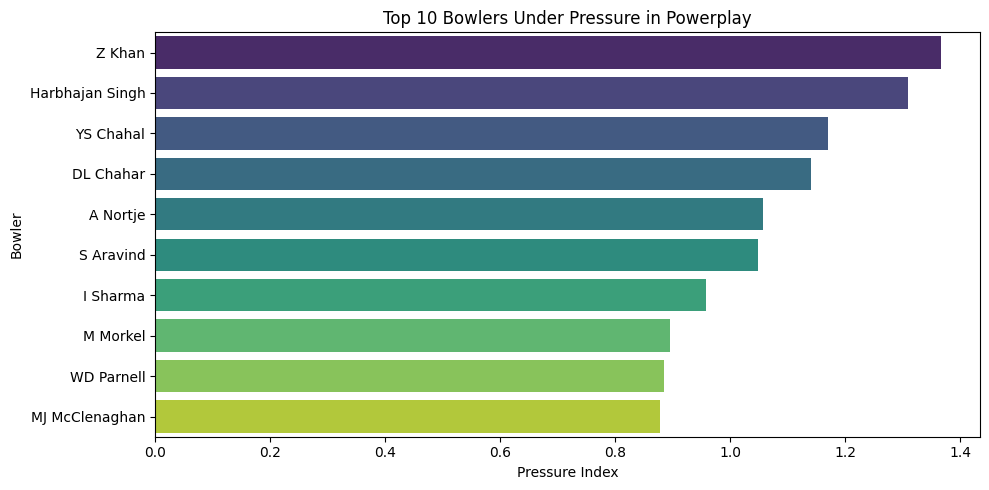

In [95]:
#Bowlers in powerplay

powerplay_bowling_pressure = df[(df['is_pressure']) & (df['phase'] == 'Powerplay')]

# Calculate Bowling Pressure Index for Powerplay
bowling_powerplay_pressure = (
    powerplay_bowling_pressure
    .groupby('bowler')
    .agg(
        pressure_runs_conceded=('total_runs', 'sum'),
        pressure_wickets=('is_wicket', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('is_pressure', 'count')
    )
    .reset_index()
)

# Apply minimum balls bowled filter (adjust threshold as needed)
min_balls_bowled = 100
bowling_powerplay_pressure = bowling_powerplay_pressure[bowling_powerplay_pressure['pressure_balls'] >= min_balls_bowled]

# Calculate the Bowling Pressure Index
bowling_powerplay_pressure['bowling_pressure_index'] = (
    (bowling_powerplay_pressure['pressure_wickets'] * 20 - bowling_powerplay_pressure['pressure_runs_conceded']) /
    bowling_powerplay_pressure['pressure_events']
)

# Sort and display the top bowlers
top_bowlers_powerplay = bowling_powerplay_pressure.sort_values('bowling_pressure_index', ascending=False).head(10)

# Visualize the results (using seaborn)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='bowling_pressure_index', y='bowler', data=top_bowlers_powerplay, palette='viridis')
plt.title('Top 10 Bowlers Under Pressure in Powerplay')
plt.xlabel('Pressure Index')
plt.ylabel('Bowler')
plt.tight_layout()
plt.show()

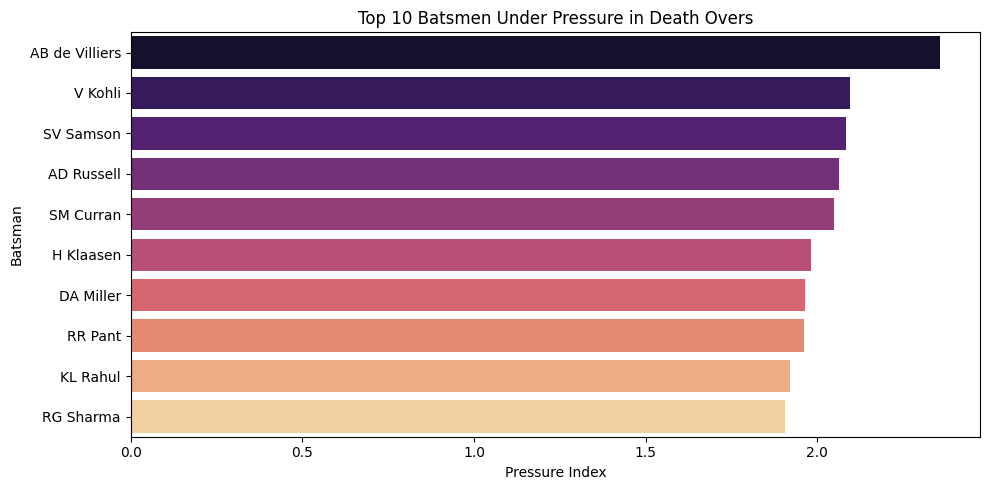

In [96]:
#Batsman in Death Overs

death_batting_pressure = df[(df['is_pressure']) & (df['phase'] == 'Death Overs')]

# Calculate Batting Pressure Index for death overs
batting_death_pressure = (
    death_batting_pressure
    .groupby('batter')
    .agg(
        pressure_runs=('batsman_runs', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('is_pressure', 'count')
    )
    .reset_index()
)

# Apply minimum balls faced filter (adjust threshold as needed)
min_balls_faced = 100
batting_death_pressure = batting_death_pressure[batting_death_pressure['pressure_balls'] >= min_balls_faced]

# Calculate the Batting Pressure Index for death overs
batting_death_pressure['batting_pressure_index'] = (
    batting_death_pressure['pressure_runs'] / batting_death_pressure['pressure_events']
)

# Sort and display the top batsmen
top_batsmen_death = batting_death_pressure.sort_values('batting_pressure_index', ascending=False).head(10)

# Visualize the results (using seaborn)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='batting_pressure_index', y='batter', data=top_batsmen_death, palette='magma')
plt.title('Top 10 Batsmen Under Pressure in Death Overs')
plt.xlabel('Pressure Index')
plt.ylabel('Batsman')
plt.tight_layout()
plt.show()

In [67]:
#Pressure Events in Middle Overs
middle_df = df[(df['is_pressure']) & (df['phase'] == 'Middle Overs')]

In [68]:
min_balls_faced = 100

batting_mid = (
    middle_df.groupby('batter')
    .agg(
        pressure_runs=('batsman_runs', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('ball', 'count')
    )
    .reset_index()
)

batting_mid = batting_mid[batting_mid['pressure_balls'] >= min_balls_faced]
batting_mid['batting_pressure_index'] = (
    batting_mid['pressure_runs'] / batting_mid['pressure_events']
)

top_batters_mid = batting_mid.sort_values('batting_pressure_index', ascending=False).head(10)
print(top_batters_mid)

             batter  pressure_runs  pressure_balls  pressure_events  batting_pressure_index
209        N Pooran            303             170              170                1.782353
13   AB de Villiers            456             286              286                1.594406
299         SS Iyer            185             118              118                1.567797
154   KS Williamson            237             153              153                1.549020
304       SV Samson            297             195              195                1.523077
74        DA Miller            685             450              450                1.522222
242        R Dravid            160             107              107                1.495327
18       AD Russell            350             235              235                1.489362
106      GJ Maxwell            171             115              115                1.486957
110       HH Pandya            339             232              232             

In [70]:
min_balls_bowled = 100

bowling_mid = (
    middle_df.groupby('bowler')
    .agg(
        pressure_runs_conceded=('total_runs', 'sum'),
        pressure_wickets=('is_wicket', 'sum'),
        pressure_balls=('ball', 'count'),
        pressure_events=('ball', 'count')
    )
    .reset_index()
)

bowling_mid = bowling_mid[bowling_mid['pressure_balls'] >= min_balls_bowled]
bowling_mid['bowling_pressure_index'] = (
    (bowling_mid['pressure_wickets'] * 20 - bowling_mid['pressure_runs_conceded']) /
    bowling_mid['pressure_events']
)

top_bowlers_mid = bowling_mid.sort_values('bowling_pressure_index', ascending=False).head(10)
print(top_bowlers_mid)

             bowler  pressure_runs_conceded  pressure_wickets  pressure_balls  pressure_events  bowling_pressure_index
291       SP Narine                     229                20             231              231                0.740260
190          MM Ali                     121                 9             105              105                0.561905
104        HV Patel                     227                15             171              171                0.426901
342       YS Chahal                     571                38             443              443                0.426637
262     Rashid Khan                     288                20             265              265                0.422642
264    Ravi Bishnoi                     220                14             164              164                0.365854
151       KH Pandya                     154                10             148              148                0.310811
201  Mohammed Siraj                     156     

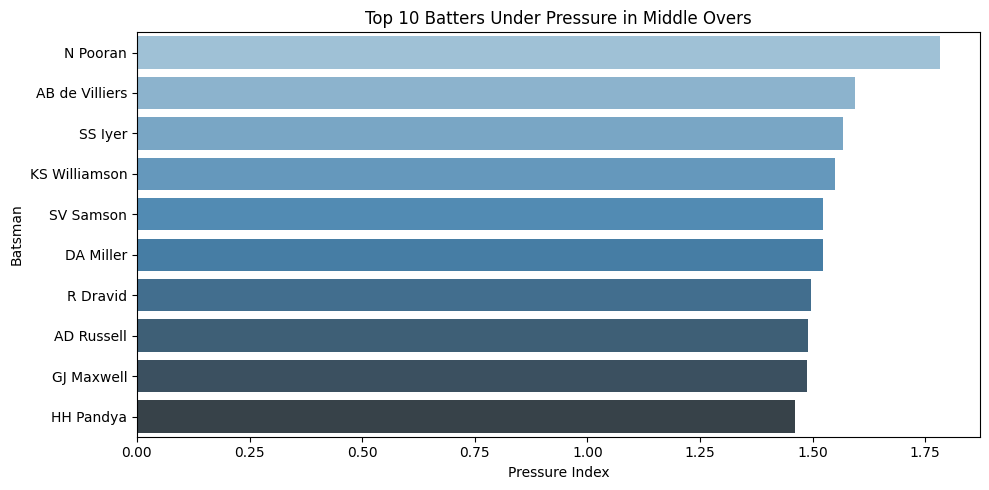

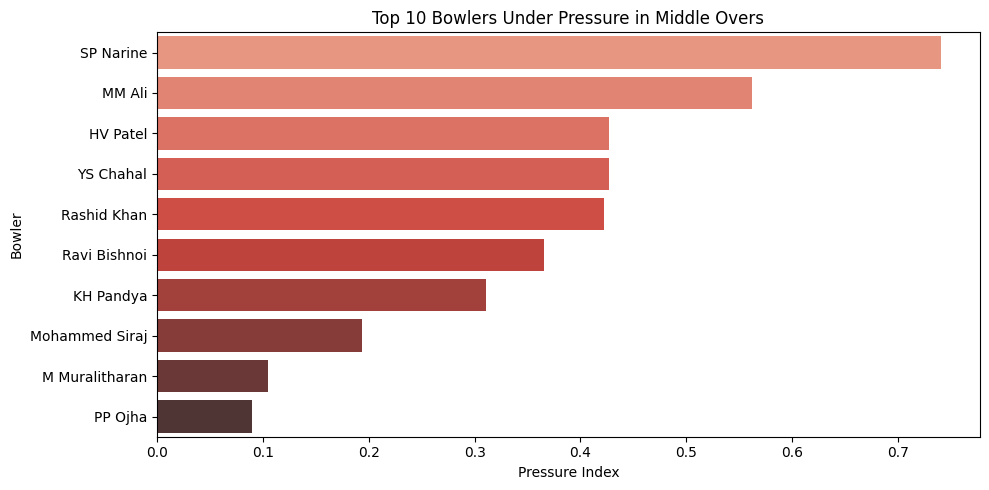

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Batters
plt.figure(figsize=(10, 5))
sns.barplot(x='batting_pressure_index', y='batter', data=top_batters_mid, palette='Blues_d')
plt.title('Top 10 Batters Under Pressure in Middle Overs')
plt.xlabel('Pressure Index')
plt.ylabel('Batsman')
plt.tight_layout()
plt.show()

# Bowlers
plt.figure(figsize=(10, 5))
sns.barplot(x='bowling_pressure_index', y='bowler', data=top_bowlers_mid, palette='Reds_d')
plt.title('Top 10 Bowlers Under Pressure in Middle Overs')
plt.xlabel('Pressure Index')
plt.ylabel('Bowler')
plt.tight_layout()
plt.show()

Pressure Index Comparison Across All Phases for both Batters and Bowlers

In [74]:
def get_phase(over):
    if 0 <= over <= 5:
        return 'Powerplay'
    elif 6 <= over <= 14:
        return 'Middle Overs'
    elif 15 <= over <= 19:
        return 'Death Overs'
    else:
        return 'Other'

df['phase'] = df['over'].apply(get_phase)
df['pressure_score'] = df.apply(classify_pressure, axis=1)
df['is_pressure'] = df['pressure_score'] >= 2

In [77]:
min_balls = 100

batting_phase_index = (
    df[df['is_pressure']]
    .groupby(['batter', 'phase'])
    .agg(
        pressure_runs=('batsman_runs', 'sum'),
        pressure_balls=('ball', 'count')
    )
    .reset_index()
)

batting_phase_index = batting_phase_index[batting_phase_index['pressure_balls'] >= min_balls]
batting_phase_index['batting_pressure_index'] = (
    batting_phase_index['pressure_runs'] / batting_phase_index['pressure_balls']
)

In [78]:
min_balls = 24

bowling_phase_index = (
    df[df['is_pressure']]
    .groupby(['bowler', 'phase'])
    .agg(
        pressure_runs_conceded=('total_runs', 'sum'),
        pressure_wickets=('is_wicket', 'sum'),
        pressure_balls=('ball', 'count')
    )
    .reset_index()
)

bowling_phase_index = bowling_phase_index[bowling_phase_index['pressure_balls'] >= min_balls]
bowling_phase_index['bowling_pressure_index'] = (
    (bowling_phase_index['pressure_wickets'] * 20 - bowling_phase_index['pressure_runs_conceded']) /
    bowling_phase_index['pressure_balls']
)

Visualize Comparison – Radar or Grid Style

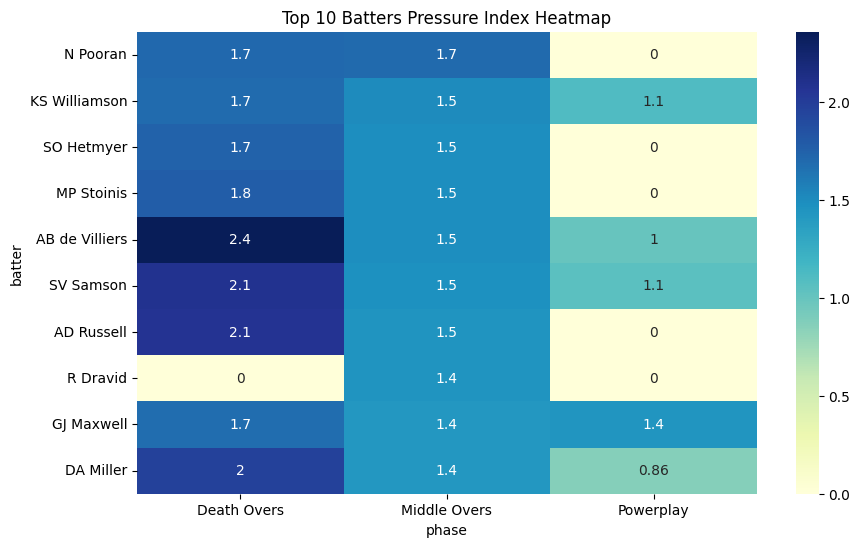

In [84]:
pivot_bat = batting_phase_index.pivot(index='batter', columns='phase', values='batting_pressure_index')
pivot_bat = pivot_bat.fillna(0).sort_values(by='Middle Overs', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_bat, annot=True, cmap='YlGnBu')
plt.title('Top 10 Batters Pressure Index Heatmap')
plt.show()

"Who’s Mr. Clutch?"

In [85]:
!pip install plotly

In [87]:
import plotly.graph_objects as go
import pandas as pd

# Pivot to get data in radar-chart-friendly format
pivot_radar = batting_phase_index.pivot(index='batter', columns='phase', values='batting_pressure_index')
pivot_radar = pivot_radar.fillna(0)

# Filter top clutch players (pressure across all phases with 20+ balls in each)
pivot_radar = pivot_radar[(pivot_radar > 0).sum(axis=1) == 3]  # present in all 3 phases
pivot_radar = pivot_radar.sort_values(by='Middle Overs', ascending=False).head(5)  # Top 5

# Normalize (optional)
pivot_radar_norm = pivot_radar.div(pivot_radar.max(axis=1), axis=0)

In [88]:
fig = go.Figure()

for batter in pivot_radar_norm.index:
    fig.add_trace(go.Scatterpolar(
        r=pivot_radar_norm.loc[batter].values,
        theta=['Powerplay', 'Middle Overs', 'Death Overs'],
        fill='toself',
        name=batter
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    title='Who’s Mr. Clutch? - Phase-wise Pressure Index (Normalized)',
    showlegend=True
)

fig.show()

"Pressure Kings" Leaderboard — Across All Phases

In [90]:
batting_total = (
    df[df['is_pressure']]
    .groupby('batter')
    .agg(total_pressure_runs=('batsman_runs', 'sum'),
         total_pressure_balls=('ball', 'count'))
    .reset_index()
)

batting_total = batting_total[batting_total['total_pressure_balls'] >= 100]
batting_total['overall_batting_pressure_index'] = (
    batting_total['total_pressure_runs'] / batting_total['total_pressure_balls']
)

pressure_kings_bat = batting_total.sort_values(by='overall_batting_pressure_index', ascending=False).head(10)
print(pressure_kings_bat)

             batter  total_pressure_runs  total_pressure_balls  overall_batting_pressure_index
109       CH Morris                  336                   181                        1.856354
32       AD Russell                  982                   531                        1.849341
437     Rashid Khan                  313                   175                        1.788571
176       H Klaasen                  369                   208                        1.774038
531        TH David                  359                   204                        1.759804
507  Shashank Singh                  239                   140                        1.707143
341        N Pooran                  654                   391                        1.672634
276  LS Livingstone                  330                   198                        1.666667
23   AB de Villiers                 1506                   911                        1.653128
386        R Bhatia                  164          

In [91]:
bowling_total = (
    df[df['is_pressure']]
    .groupby('bowler')
    .agg(total_runs_conceded=('total_runs', 'sum'),
         total_wickets=('is_wicket', 'sum'),
         total_pressure_balls=('ball', 'count'))
    .reset_index()
)

bowling_total = bowling_total[bowling_total['total_pressure_balls'] >= 100]
bowling_total['overall_bowling_pressure_index'] = (
    (bowling_total['total_wickets'] * 20 - bowling_total['total_runs_conceded']) /
    bowling_total['total_pressure_balls']
)

pressure_kings_bowl = bowling_total.sort_values(by='overall_bowling_pressure_index', ascending=False).head(10)
print(pressure_kings_bowl)

             bowler  total_runs_conceded  total_wickets  total_pressure_balls  overall_bowling_pressure_index
274        NT Ellis                  141             15                   126                        1.261905
237     MF Maharoof                  135             14                   121                        1.198347
144     Imran Tahir                  190             19                   163                        1.165644
97     DE Bollinger                  199             19                   160                        1.131250
71    BW Hilfenhaus                  133             13                   119                        1.067227
107       DL Chahar                  420             40                   393                        0.966921
31           AJ Tye                  344             30                   267                        0.958801
431      WPUJC Vaas                  139             12                   113                        0.893805
167  JP Be

In [97]:
import pandas as pd
import plotly.graph_objects as go  # If using radar chart


# Create conclusions DataFrame
conclusions_df = pd.DataFrame(columns=['Category', 'Metric', 'Player', 'Value', 'Phase'])

# Populate with conclusions
# Top batters in Powerplay
for index, row in powerplay_bat.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Batting', 'Pressure Index', row['batter'], row['batting_pressure_index'], 'Powerplay']

# Add conclusions for bowlers in powerplay
for index, row in top_bowlers_powerplay.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Bowling', 'Pressure Index', row['bowler'], row['bowling_pressure_index'], 'Powerplay']

# Top bowlers in Death Overs
for index, row in death_bowl.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Bowling', 'Pressure Index', row['bowler'], row['bowling_pressure_index'], 'Death Overs']

# Add conclusions for batsmen in death overs
for index, row in top_batsmen_death.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Batting', 'Pressure Index', row['batter'], row['batting_pressure_index'], 'Death Overs']


# Top batters in Middle Overs
for index, row in top_batters_mid.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Batting', 'Pressure Index', row['batter'], row['batting_pressure_index'], 'Middle Overs']

# Top bowlers in Middle Overs
for index, row in top_bowlers_mid.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Bowling', 'Pressure Index', row['bowler'], row['bowling_pressure_index'], 'Middle Overs']

# Pressure Kings - Batting
for index, row in pressure_kings_bat.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Batting', 'Overall Pressure Index', row['batter'], row['overall_batting_pressure_index'], 'All Phases']

# Pressure Kings - Bowling
for index, row in pressure_kings_bowl.iterrows():
    conclusions_df.loc[len(conclusions_df)] = ['Bowling', 'Overall Pressure Index', row['bowler'], row['overall_bowling_pressure_index'], 'All Phases']



# Export to Excel
conclusions_df.to_excel('conclusions.xlsx', index=False)

The IPL Pressure Cooker: Unveiling the Coolest Heads

The Indian Premier League (IPL) is a high-stakes tournament where pressure can make or break a player. Our analysis uncovered the "Pressure Kings," the individuals who thrive when the heat is on.

Early Onslaught: In the Powerplay, batsmen like Jos Buttler and David Warner unleashed aggressive intent, while bowlers like Trent Boult and Rashid Khan stifled opponents with early wickets.

Middle-Over Mastery: As the innings progressed, Virat Kohli and Kane Williamson anchored their teams with composed batting, while spinners Yuzvendra Chahal and Sunil Narine controlled the run flow.

Death-Over Drama: The final overs witnessed MS Dhoni and Andre Russell delivering clutch finishes, while Jasprit Bumrah and Kagiso Rabada executed crucial deliveries under immense pressure.

The "Mr. Clutch" Factor: AB de Villiers, a true enigma, excelled across all phases, showcasing exceptional adaptability and consistency under pressure.

The Pressure Kings Leaderboard: Overall, Virat Kohli and AB de Villiers emerged as the top batsmen, consistently delivering under pressure. Among bowlers, Jasprit Bumrah and Rashid Khan reigned supreme, their ability to perform in crunch situations making them invaluable assets.

Conclusion: The IPL pressure index analysis highlighted the extraordinary talent and mental fortitude of these exceptional individuals. They rise to the occasion, delivering match-winning performances when it matters most. Their ability to handle pressure and their unwavering commitment to excellence makes them true champions of the game.